In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', index_col='Date', parse_dates=True)

In [ ]:
df1.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df1.isna().sum()

Currency               0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

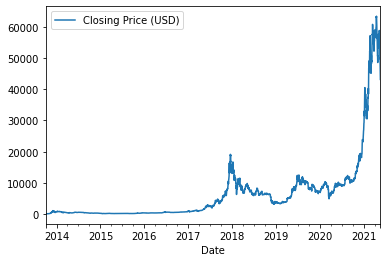

In [ ]:
df = df1[['Closing Price (USD)']].copy().dropna()
df.plot();

In [ ]:
alpha = 0.2

In [ ]:
df['EWMA'] = df['Closing Price (USD)'].ewm(alpha=alpha, adjust=False).mean()

In [ ]:
type(df['Closing Price (USD)'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

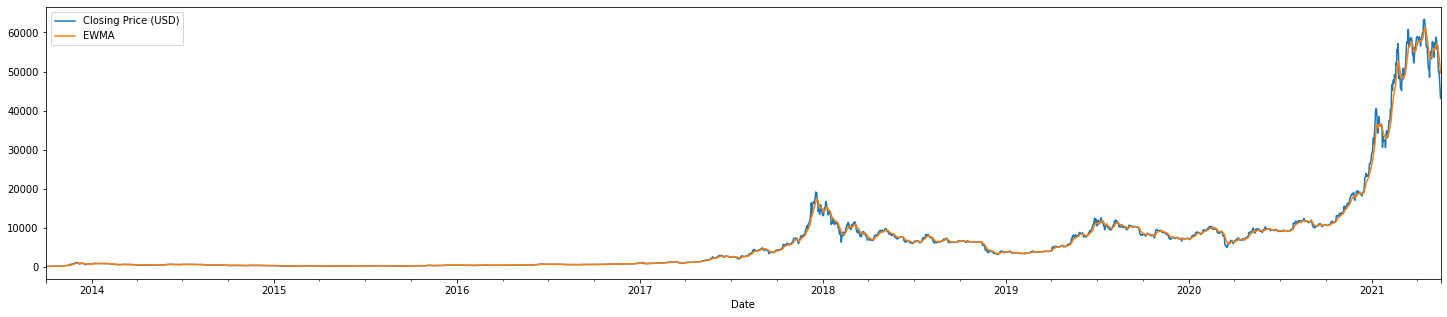

In [ ]:
df.plot(figsize=(25,5));

In [ ]:
manual_ewma = []
for x in df['Closing Price (USD)'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

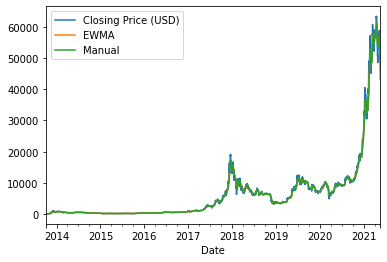

In [ ]:
df.plot();

In [ ]:
df.head()

,Closing Price (USD),EWMA,Manual
Date,,,
2013-10-01,123.65499,123.654990,123.654990
2013-10-02,125.45500,124.014992,124.014992
2013-10-03,108.58483,120.928960,120.928960
2013-10-04,118.67466,120.478100,120.478100
2013-10-05,121.33866,120.650212,120.650212


In [ ]:
df.drop('Manual', axis=1, inplace=True)

In [ ]:
pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
N_test = 100
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [ ]:
ses = SimpleExpSmoothing(
    train['Closing Price (USD)'],
    initialization_method='legacy-heuristic')
res = ses.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

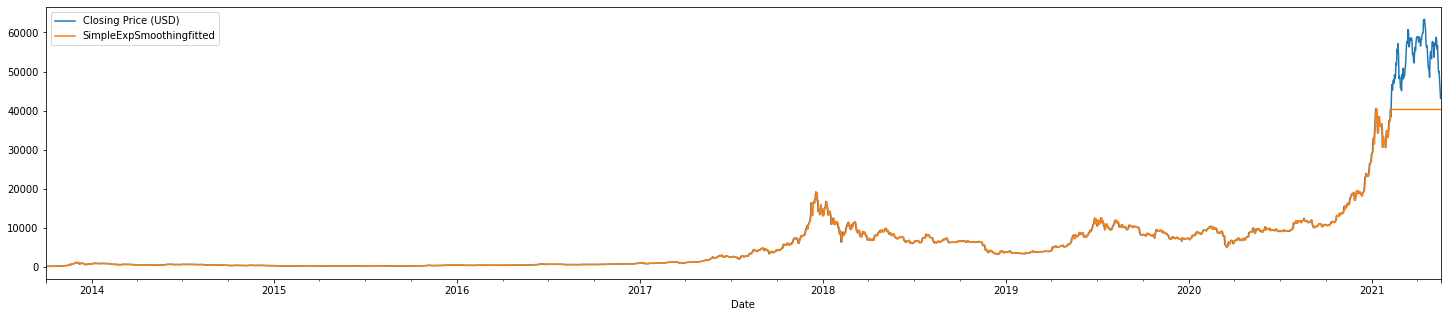

In [ ]:
df.loc[train_idx, 'SimpleExpSmoothingfitted'] = res.fittedvalues
df.loc[test_idx, 'SimpleExpSmoothingfitted'] = res.forecast(N_test)
df[['Closing Price (USD)', 'SimpleExpSmoothingfitted']].plot(figsize=(25,5));

In [ ]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 123.65499,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
holt = Holt(train['Closing Price (USD)'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt_linear'] = res_h.fittedvalues

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
df.loc[test_idx, 'Holt_linear'] = res_h.forecast(N_test)

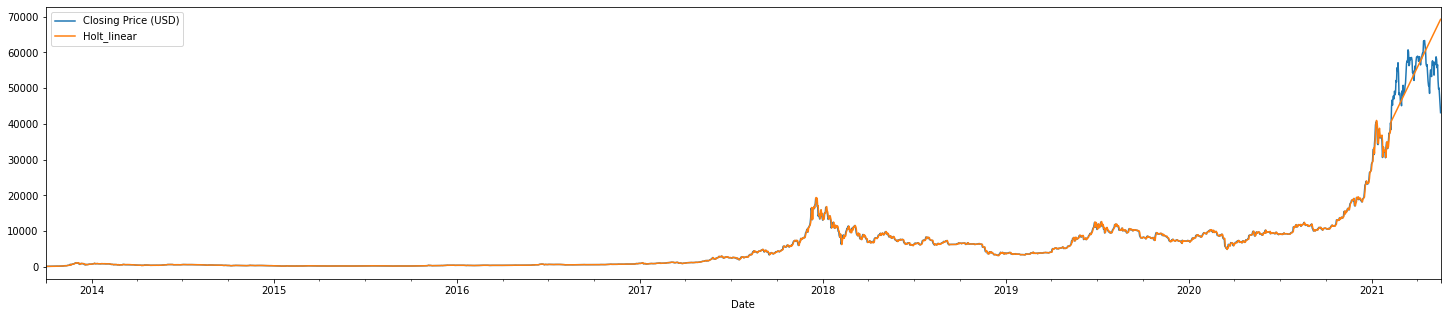

In [ ]:
df[['Closing Price (USD)', 'Holt_linear']].plot(figsize=(25,5));

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
hw = ExponentialSmoothing(
    train['Closing Price (USD)'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
df.loc[train_idx, 'HoltWinters_trend=add_seasonal=add'] = res_hw.fittedvalues

In [ ]:
df.loc[test_idx, 'HoltWinters_trend=add_seasonal=add'] = res_hw.forecast(N_test)

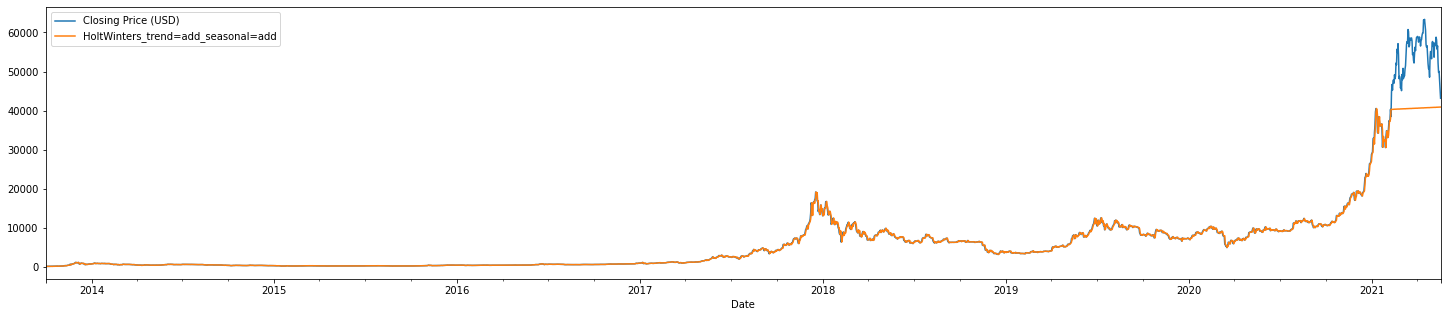

In [ ]:
df[['Closing Price (USD)','HoltWinters_trend=add_seasonal=add' ]].plot(figsize=(25,5));

In [ ]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [ ]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [ ]:
print("Train RMSE:", rmse(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train RMSE: 357.3423473805725
Test RMSE: 14311.585115243959


In [ ]:
print("Train MAE:", mae(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train MAE: 144.39985068080222
Test MAE: 13463.170085221902


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


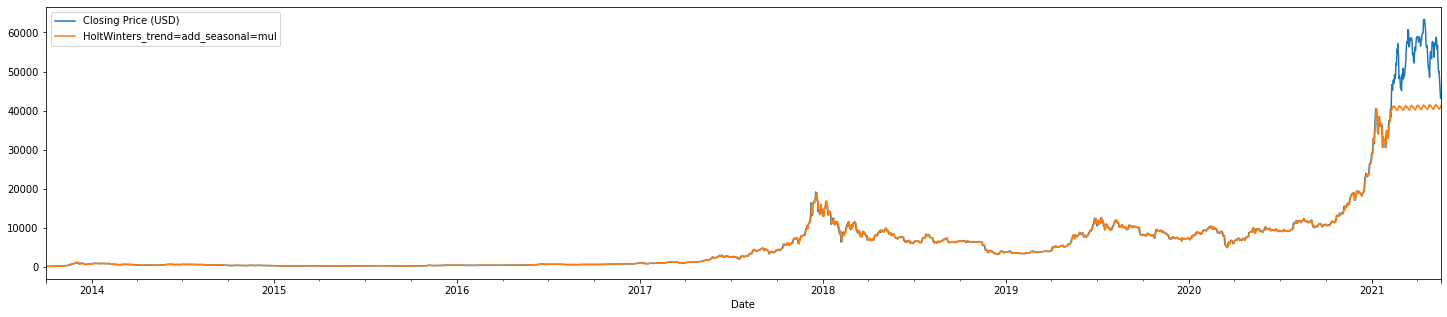

In [ ]:
hw = ExponentialSmoothing(
    train['Closing Price (USD)'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters_trend=add_seasonal=mul'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters_trend=add_seasonal=mul'] = res_hw.forecast(N_test)
df[['Closing Price (USD)', 'HoltWinters_trend=add_seasonal=mul']].plot(figsize=(25,5));

In [ ]:
print("Train RMSE:", rmse(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train RMSE: 361.2836992958372
Test RMSE: 14153.952389190077


In [ ]:
print("Train MAE:", mae(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train MAE: 149.27938387402116
Test MAE: 13287.094513334234


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


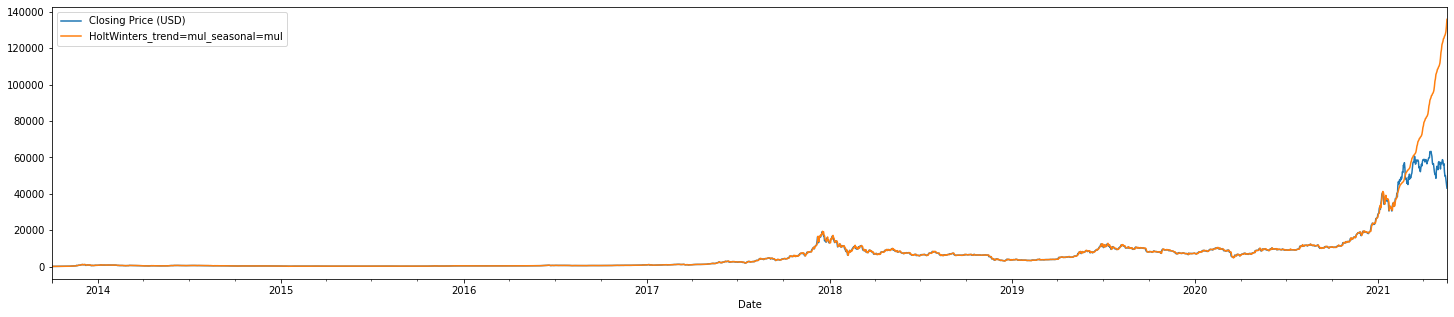

In [ ]:
hw = ExponentialSmoothing(
    train['Closing Price (USD)'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters_trend=mul_seasonal=mul']= res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters_trend=mul_seasonal=mul'] = res_hw.forecast(N_test)
df[['Closing Price (USD)', 'HoltWinters_trend=mul_seasonal=mul']].plot(figsize=(25,5));

In [ ]:
print("Train RMSE:", rmse(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train RMSE: 365.1868046597277
Test RMSE: 36094.327953926135


In [ ]:
print("Train MAE:", mae(train['Closing Price (USD)'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Closing Price (USD)'], res_hw.forecast(N_test)))

Train MAE: 151.489490367318
Test MAE: 26471.661642311705


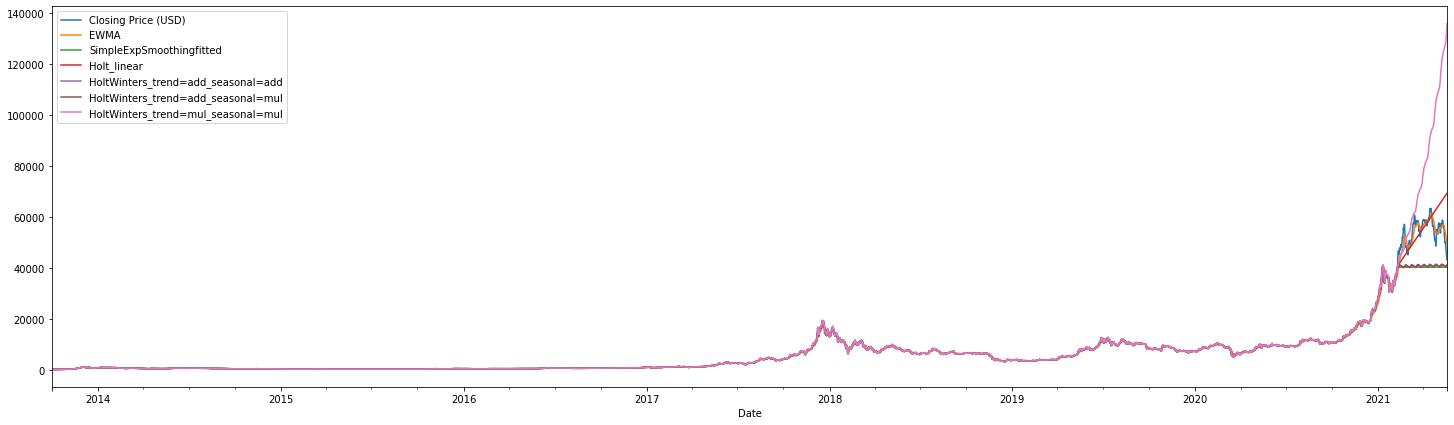

In [ ]:
df.plot(figsize=(25,7));